In [24]:
import os, sys
sys.path.append('../MLinPhysics/python')

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# module to access data in Hierarchical Data Format (HDF or H5 format)
import h5py

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

#from lossmonitor import TimeLeft

 #update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": False, # turn off if the system can't find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

In [25]:

from lossmonitor import TimeLeft

In [26]:
with h5py.File('train_data_equal.h5', 'r') as f:
    dataset_structure = {key: list(f[key]) if isinstance(f[key], h5py.Group) else f[key].shape for key in f.keys()}
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]

with h5py.File('test_data_equal.h5', 'r') as f:
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

with h5py.File('val_data_equal.h5', 'r') as f:
    X_val = f['X_val'][:]
    y_val = f['y_val'][:]

print(f"Loaded Training Events: {len(X_train)}")
print(f"Loaded Test Events: {len(X_test)}")
print(f"Loaded Validation Events: {len(X_val)}")


Loaded Training Events: 70000
Loaded Test Events: 15000
Loaded Validation Events: 15000


In [29]:
import numpy as np

# Count unique values and their occurrences
unique_labels, counts = np.unique(y_train, return_counts=True)
print(f"Label distribution in y_train: {dict(zip(unique_labels, counts))}")

# Similarly for X_test and X_val
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
unique_labels_val, counts_val = np.unique(y_val, return_counts=True)

print(f"Label distribution in y_test: {dict(zip(unique_labels_test, counts_test))}")
print(f"Label distribution in y_val: {dict(zip(unique_labels_val, counts_val))}")


Label distribution in y_train: {np.float32(0.0): np.int64(35000), np.float32(1.0): np.int64(35000)}
Label distribution in y_test: {np.float32(0.0): np.int64(7500), np.float32(1.0): np.int64(7500)}
Label distribution in y_val: {np.float32(0.0): np.int64(7500), np.float32(1.0): np.int64(7500)}


In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [30]:
def delta_phi(phi2, phi1):
    deltaphi = phi2 - phi1
    abs_deltaphi = torch.abs(deltaphi)
    deltaphi = torch.where(abs_deltaphi > torch.pi, 
                           2 * torch.pi - abs_deltaphi, 
                           abs_deltaphi)
    return deltaphi

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
PARAMS_FILE = 'GNN.pth'
LOSS_FILE = 'losses.csv'
TIMELEFT_FILE = 'timeleft.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


In [32]:
class Edges(nn.Module):
    '''
    Given a set of vertices V, compute adjacency matrix of shape (n, n).
    '''    
    def __init__(self, alpha=1, device=DEVICE):

        super().__init__()

        # Note use of Parameter to tell PyTorch that the parameter alpha
        # is to be fitted.
        self.alpha = nn.Parameter(alpha * torch.rand(1))

        self.device = device
        
    def forward(self, x):

        # 1. compute square of Euclidean distance in (eta, phi) space
        #    dR^2 = deta^2 + dphi^2
        eta, phi = x[:, 1], x[:, 2]
        # here is a nice example of the mechanism of broadcasting: 
        # by changing the shapes to view(-1, 1) and view(1, -1), we
        # can, in a single line, compute all possible differences.
        # consequently, the shapes of the following tensors will be (n, n)
        deta = eta.view(-1, 1) - eta.view(1, -1)
        dphi = delta_phi(phi.view(-1, 1), phi.view(1, -1))
        dRdR = deta**2 + dphi**2

        # 2. compute exp(- alpha * dR)**2)
        A = torch.exp(-self.alpha * dRdR)

        # 3. apply softmax in horizontal direction.
        #    adding a unit matrix to the adjacency matrix 
        #    makes the training more stable. we need to send
        #    the unit matrix to the computatational device.
        A = torch.softmax(A, dim=1) + torch.eye(len(x)).to(self.device)
        
        return A

In [33]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_features, out_features, scale=0.05):

        # initialize base class
        super().__init__()

        # we embed the "n" input vertices in a larger vector space 
        # of dimension h = out_features
        self.embed  = nn.Linear(in_features, out_features)
        
        self.weight = nn.Parameter(scale * (2*torch.rand(out_features, out_features)-1.0))
        self.bias   = nn.Parameter(scale * (2*torch.rand(1)-1.0))

    def forward(self, X, A):

        # embed vertices in a larger vector space
        X = self.embed(X)
        X = F.relu(X)

        # perform graph convolution. for each vertex, this operation
        # performs a weighted sum of the features of all other vertices,
        # weighting the nearest neighbors more heavily.
        # AX = A * X
        AX = torch.matmul(A, X)

        # compute (A * X) * W + B * I
        X = torch.matmul(AX, self.weight) + self.bias * torch.ones_like(X)
        X = F.relu(X)

        # return modified vertices  
        return X

class VerticalSum(nn.Module):
    '''
    Perform a permutation and vertex count-invariant operation on the
    vertices of a graph.
    '''
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = x.sum(dim=0)
        return x

In [34]:
class GNN(nn.Module):
    
    def __init__(self, n_dim, n_embed=40):

        # initialize base class
        super().__init__()

        self.edges  = Edges()
        self.gconv1 = GCNLayer(n_dim,   n_embed)
        self.gconv2 = GCNLayer(n_embed, n_embed)
        self.vsum   = VerticalSum()
        self.linear = nn.Linear(n_embed, 1)

    def forward(self, x):

        # construct n x n adjacency matrix which together
        # with the vertices V = x forms the graph G = (V, E)
        V = x
        E = self.edges(V)
        
        # pass graph G = (V, E) through multiple
        # graph convolution layers (graph processors)
        V = self.gconv1(V, E)
        V = F.relu(V)
        
        V = self.gconv2(V, E)
        V = F.relu(V)
        
        # apply a permutation- and vertex count-invariant
        # function to the vertices 
        x = self.vsum(V)

        # complete with a simple MLP
        x = self.linear(x)     
        x = F.sigmoid(x)
        
        return x

    def save(self, paramsfile):
        # save parameters of neural network
        torch.save(self.state_dict(), paramsfile)

    def load(self, paramsfile):
        # load parameters of neural network
        self.eval()
        self.load_state_dict(torch.load(paramsfile))

In [35]:
# Note: there are several average loss functions available 
# in PyTorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t):
    # f and t must be of the same shape
    # f = torch.where(f >= 1, 0.9999, f)
    losses = torch.where(t > 0.5, torch.log(f), torch.log(1-f))
    return -torch.mean(losses)

In [36]:
def empirical_risk(model, lossfn, X, Y):        
    out = model(X[0]) 
    loss = lossfn(out, Y[0])

    for x, y in zip(X[1:], Y[1:]):
        out = model(x)
        loss += lossfn(out, y)
    loss /= len(X)
    return loss

def emprirical_risk_one_at_a_time(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

In [37]:
class DataLoader:
    
    def __init__(self, X, T, batch_size=1):
        self.X = X
        self.T = T
        
        self.B = batch_size
        self.N = len(X)
        
        self.reset()
        
    def reset(self):
        self.A = self.N / self.B
        self.J = int(self.A) + 1
        
        self.start = 0
        self.end = B
        self.ii = -1
        
    def __call__(self, ii=-1):

        if ii > self.ii:

            # update start and end of batch
            
            if self.B < 2:  # assume random selection
                self.start = torch.randint(0, self.N-1, size=(1,))
                self.end = self.start + 1
                
            else: 
                self.J += 1
                if self.J >= self.A:
                    self.J = 0
                    self.start = 0
                    self.end = self.B
                else:
                    self.start += self.B
                    self.end = self.start + self.B
                    if self.end > self.N:
                        self.end = self.N

        self.ii = ii
        
        return self.X[self.start:self.end], self.T[self.start:self.end]

In [38]:
def train(model, optimizer, lossfn, 
          t_dataloader, v_dataloader1, v_dataloader2,
          number_iterations,
          lossfile=LOSS_FILE,
          timeleftfile=TIMELEFT_FILE,
          paramsfile=PARAMS_FILE,
          step=100):

    # start saving model parameters after the following number of iterations.
    start_saving = number_iterations // 100
    min_avloss   = float('inf')  # initialize minimum average loss

    # initialize loss file
    # create loss file if it does not exist
    if not os.path.exists(lossfile):
        open(lossfile, 'w').write('iteration,t_loss,v_loss\n')  

    # get last iteration number from loss file
    df = pd.read_csv(lossfile)
    if len(df) < 1:
        itno = 0
    else:
        itno = df.iteration.iloc[-1] # get last iteration number

    # ------------------------------------------
    # enter training loop
    # ------------------------------------------
    timeleft = TimeLeft(number_iterations)
    
    for ii in range(number_iterations):
        
        # set mode to training so that training-specific 
        # operations such as dropout, etc., are enabled.

        model.train() # training mode

        x, y = t_dataloader(ii)
        
        loss = empirical_risk(model, lossfn, x, y)
    
        optimizer.zero_grad()  # clear previous gradients
    
        loss.backward()        # compute gradients
    
        optimizer.step()       # move one step
    
        # i'm alive printout
        
        if (ii % step == 0) and (ii > 0):

            with torch.no_grad():
                
                model.eval()
                
                # compute average loss on train data
                x, y = v_dataloader1()
                t_loss = empirical_risk(model, lossfn, x, y).detach()

                # compute average loss on validation data
                x, y = v_dataloader2()
                v_loss = empirical_risk(model, lossfn, x, y).detach()
     
            # update loss file
            
            open(loss_file, 'a').write(f'{itno:12d},{t_loss:12.8},{v_loss:12.8}\n')

            # save model paramters to file
            
            if v_loss < min_avloss:
                min_avloss = v_loss
                if ii > start_saving:
                    model.save(paramsfile)

            # update time left file
            
            line = f'|{itno:12d}|{t_loss:12.8f}|{v_loss:12.8f}|'
            timeleft(ii, line)
            open(timeleftfile, 'w').write(f'{str(timeleft):s}\n')

            # update iteration number
            
            itno += step

    print()      
    return 

In [39]:
_, n_dimensions = X_train[0].shape

model = GNN(n_dimensions).to(DEVICE)
print('number of parameters:', number_of_parameters(model))

print(model)
print()

for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)
        #print(p)
        #print()

number of parameters: 5044
GNN(
  (edges): Edges()
  (gconv1): GCNLayer(
    (embed): Linear(in_features=3, out_features=40, bias=True)
  )
  (gconv2): GCNLayer(
    (embed): Linear(in_features=40, out_features=40, bias=True)
  )
  (vsum): VerticalSum()
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

edges.alpha
gconv1.weight
gconv1.bias
gconv1.embed.weight
gconv1.embed.bias
gconv2.weight
gconv2.bias
gconv2.embed.weight
gconv2.embed.bias
linear.weight
linear.bias


In [40]:
X = [0,1,2,3,4,5,6]
Y = [0,11,22,33,44,55,66]
B = 3
dataloader = DataLoader(X, Y, B)

for i in range(10):
    x, y = dataloader(i)
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')

print()

dataloader.reset()

for i in range(10):
    x, y = dataloader()
    print(f'{i:5d}\t{str(x):10s}\t{str(y):10s}')


    0	[0, 1, 2] 	[0, 11, 22]
    1	[3, 4, 5] 	[33, 44, 55]
    2	[6]       	[66]      
    3	[0, 1, 2] 	[0, 11, 22]
    4	[3, 4, 5] 	[33, 44, 55]
    5	[6]       	[66]      
    6	[0, 1, 2] 	[0, 11, 22]
    7	[3, 4, 5] 	[33, 44, 55]
    8	[6]       	[66]      
    9	[0, 1, 2] 	[0, 11, 22]

    0	[0, 1, 2] 	[0, 11, 22]
    1	[0, 1, 2] 	[0, 11, 22]
    2	[0, 1, 2] 	[0, 11, 22]
    3	[0, 1, 2] 	[0, 11, 22]
    4	[0, 1, 2] 	[0, 11, 22]
    5	[0, 1, 2] 	[0, 11, 22]
    6	[0, 1, 2] 	[0, 11, 22]
    7	[0, 1, 2] 	[0, 11, 22]
    8	[0, 1, 2] 	[0, 11, 22]
    9	[0, 1, 2] 	[0, 11, 22]


In [55]:
loss_file = LOSS_FILE
timeleft_file = TIMELEFT_FILE
params_file = PARAMS_FILE

n_iterations = 500000
step = 100
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

avloss = average_cross_entropy_loss

t_dataloader  = DataLoader(X_train, y_train)
v_dataloader1 = DataLoader(X_train, y_train, 15000)
v_dataloader2 = DataLoader(X_val, y_val, 15000)

In [56]:
DELETE_LOSS_FILE = True

if DELETE_LOSS_FILE:
    os.system(f'rm -f {loss_file:s}')

train(model, optimizer, avloss, 
      t_dataloader, v_dataloader1, v_dataloader2, 
      n_iterations,
      loss_file, timeleft_file, params_file, 
      step)

    499901| 99.98%|00:25:03/00:00:00| 332.5 it/s|      499800|  0.39205134|  0.09653755|


In [57]:
def plot_confusion_matrix(y, y_pred, gfile='confusion_matrix.png'):
    from sklearn.metrics import confusion_matrix
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

    # plot the confusion matrix using matplotlib
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.rainbow, alpha=0.4)

    # annotate each plot with target
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], 
                    va='center', ha='center', size='x-large')
 
    plt.xlabel('Predicted Labels', fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.title(f'Confusion Matrix', fontsize=16)
    
    fig.tight_layout()
    plt.savefig(gfile)

In [58]:
model.load(params_file)

y_hat = []
for i in tqdm(range(len(X_test))):
    y_hat.append(float(model(X_test[i]).data.cpu()))

y_hat  = np.array(y_hat)
y_pred = (y_hat > 0.5).astype(int)
y_true = y_test.data.cpu().numpy()

/var/folders/9x/5y5sll196kv_267td22lbxpc0000gn/T/ipykernel_18743/1992149069.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(paramsfile))

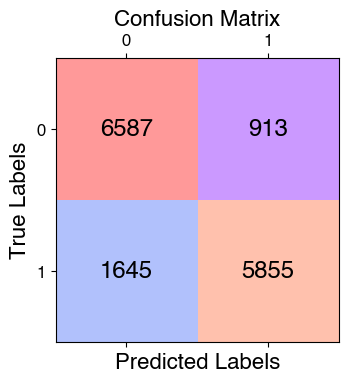

In [59]:
plot_confusion_matrix(y_true, y_pred)

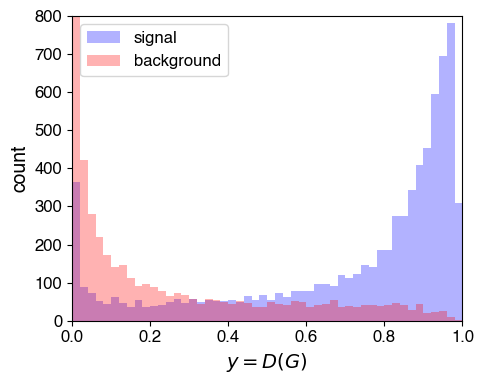

In [68]:
def plot_outputs(y, yhat, 
                 xbins=50, xmin=0, xmax=1,
                 ymin=0, ymax=800, 
                 filename='outputs.png',
                 fgsize=(5, 4),
                 ftsize=14):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'$y = D(G)$', fontsize=ftsize)
    ax.set_ylabel(r'count', fontsize=ftsize)

    s = yhat[y > 0.5]
    b = yhat[y < 0.5]
    
    ax.hist(s, bins=xbins, range=(xmin, xmax), color='blue', alpha=0.3, label='signal')
    ax.hist(b, bins=xbins, range=(xmin, xmax), color='red', alpha=0.3, label='background')
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(filename)

plot_outputs(y_true, y_hat)

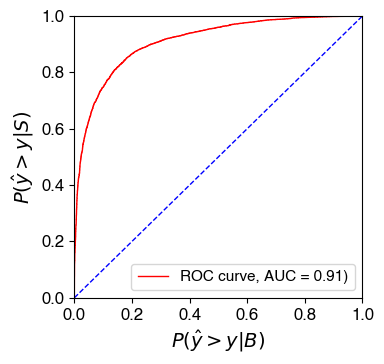

In [61]:
def plot_roc(y, yhat):
    # standard measures of model performance
    from sklearn.metrics import roc_curve, auc

    bkg, sig, _ = roc_curve(y, yhat)
    
    roc_auc = auc(bkg, sig)
    
    fig = plt.figure(figsize=(4.0, 3.8))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$P(\\hat{y} > y | B)$', fontsize=14)
    plt.ylabel('$P(\\hat{y} > y | S)$', fontsize=14)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    fig.tight_layout()
    plt.savefig("ROC.png")

plot_roc(y_true, y_hat)

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_pdata(yhat_sig, epsilon):
    """
    Compute p_data(x) based on model probabilities and epsilon.
    """
    yhat_bkg = 1 - yhat_sig  # Background probability
    return epsilon * yhat_sig + (1 - epsilon) * yhat_bkg

def compute_anomaly_score(pdata, yhat_bkg):
    """
    Compute anomaly score using the formula pdata / pbkg
    """
    return pdata / yhat_bkg


In [78]:
import torch

# Example: Assuming yhat_sig is a PyTorch tensor from your model output
yhat_sig = model(X_val)  # output of your model, PyTorch tensor

# Apply sigmoid and detach (assuming model output is logits)
yhat_sig = torch.sigmoid(yhat_sig).detach()

# Now you can proceed to compute pdata using PyTorch operations
epsilon = 0.5
yhat_bkg = 1 - yhat_sig  # Background probability

# Compute p_data(x) directly as a PyTorch tensor
pdata = epsilon * yhat_sig + (1 - epsilon) * yhat_bkg

# Compute anomaly scores using the formula pdata / pbkg
anomaly_scores = pdata / yhat_bkg

# Define a threshold for anomaly detection
threshold = 0.91

# Classify anomalies based on threshold
anomalies = anomaly_scores > threshold

# To visualize the ROC curve (assuming y_true is a PyTorch tensor as well)
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true.numpy(), anomaly_scores.numpy())  # Convert to NumPy if needed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend()
plt.show()


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Your existing function to plot distributions of signal and background
def plot_outputs(y, yhat, 
                 xbins=50, xmin=0, xmax=1,
                 ymin=0, ymax=800, 
                 filename='outputs.png',
                 fgsize=(5, 4),
                 ftsize=14):
    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    
    nrows, ncols, index = 1, 1, 1
    ax = fig.add_subplot(nrows, ncols, index)
        
    # setup axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel(r'$y = D(G)$', fontsize=ftsize)
    ax.set_ylabel(r'count', fontsize=ftsize)

    s = yhat[y > 0.5]
    b = yhat[y < 0.5]
    
    ax.hist(s, bins=xbins, range=(xmin, xmax), color='blue', alpha=0.3, label='signal')
    ax.hist(b, bins=xbins, range=(xmin, xmax), color='red', alpha=0.3, label='background')
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(filename)

# Your function to plot the ROC curve
def plot_roc(y, yhat):
    # standard measures of model performance
    fpr, tpr, _ = roc_curve(y, yhat)
    roc_auc = auc(fpr, tpr)
    
    fig = plt.figure(figsize=(4.0, 3.8))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$P(\\hat{y} > y | B)$', fontsize=14)
    plt.ylabel('$P(\\hat{y} > y | S)$', fontsize=14)
    
    plt.plot(fpr, tpr, color='red', lw=1, label=f'ROC curve, AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    fig.tight_layout()
    plt.savefig("ROC.png")

# Define the functions for anomaly detection
def compute_pdata(yhat_sig, epsilon):
    """
    Compute p_data(x) based on model probabilities and epsilon.
    """
    yhat_bkg = 1 - yhat_sig  # Background probability
    return epsilon * yhat_sig + (1 - epsilon) * yhat_bkg

def compute_anomaly_score(pdata, yhat_bkg):
    """
    Compute anomaly score using the formula pdata / pbkg
    """
    return pdata / yhat_bkg

# Example of how to integrate the anomaly detection into the existing code
def perform_anomaly_detection(model, X_val, y_true, epsilon=0.5, threshold=0.91):
    # Predict probabilities for signal class (output of your GNN model)
    yhat_sig = model(X_val)  # Assuming X_val is the validation data
    
    # If the model outputs logits, apply sigmoid to convert to probabilities
    yhat_sig = torch.sigmoid(yhat_sig).detach().numpy()  # Ensure it's a numpy array
    
    # Compute p_data(x)
    pdata = compute_pdata(yhat_sig, epsilon)

    # Compute anomaly scores: pdata / p_bkg
    anomaly_scores = compute_anomaly_score(pdata, 1 - yhat_sig)

    # Plot output distributions (signal vs background)
    plot_outputs(y_true, yhat_sig)

    # Plot ROC curve using the anomaly scores
    plot_roc(y_true, anomaly_scores)
    
    # Optionally, use a threshold to classify anomalies (this step depends on your use case)
    anomalies = anomaly_scores > threshold
    return anomalies, anomaly_scores

# Example usage with your model:
# Assuming you have already trained the model and have X_val and y_true
anomalies, anomaly_scores = perform_anomaly_detection(model, X_val, y_true, epsilon=0.5, threshold=0.91)

# `anomalies` now contains a boolean array where True means anomaly detected


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.